# LSTM-Based Time Series with PyTorch

- https://www.youtube.com/playlist?list=PLjy4p-07OYzuy_lHcRW8lPTLPTTOmUpmi
- https://colab.research.google.com/github/jeffheaton/app_deep_learning/blob/main/t81_558_class_10_2_lstm.ipynb

In [ ]:
# Make use of a GPU or MPS (Apple) if one is available.  (see module 3.2)
import torch
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## Part 10.2: LSTM-Based Time Series with PyTorch

So far, the neural networks that we’ve examined have always had forward connections. Neural networks of this type always begin with an input layer connected to the first hidden layer. Each hidden layer always connects to the next hidden layer. The final hidden layer always connects to the output layer. This manner of connection is why these networks are called "feedforward." Recurrent neural networks are not as rigid, as backward linkages are also allowed. A recurrent connection links a neuron in a layer to either a previous layer or the neuron itself. Most recurrent neural network architectures maintain the state in the recurrent connections. Feedforward neural networks don’t keep any state.

### Understanding LSTM

Long Short Term Memory (LSTM) layers are a type of recurrent unit that you often use with deep neural networks.[[Cite:hochreiter1997long]](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.676.4320) For TensorFlow, you can think of LSTM as a layer type that you can combine with other layer types, such as dense. LSTM makes use of two transfer function types internally.  

The first type of transfer function is the sigmoid.  This transfer function type is used form gates inside of the unit.  The sigmoid transfer function is given by the following equation:

$ \mbox{S}(t) = \frac{1}{1 + e^{-t}} $

The second type of transfer function is the hyperbolic tangent (tanh) function, which allows you to scale the output of the LSTM. This functionality is similar to how we have used other transfer functions in this course.  

We provide the graphs for these functions here:

Sigmoid


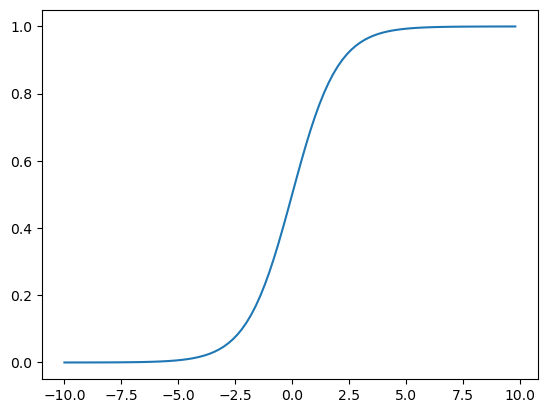

Hyperbolic Tangent(tanh)


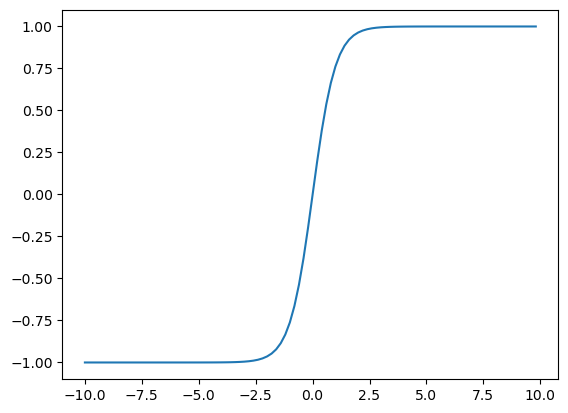

In [ ]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math

def sigmoid(x):
    a = []
    for item in x:
        a.append(1/(1+math.exp(-item)))
    return a

def f2(x):
    a = []
    for item in x:
        a.append(math.tanh(item))
    return a

x = np.arange(-10., 10., 0.2)
y1 = sigmoid(x)
y2 = f2(x)

print("Sigmoid")
plt.plot(x,y1)
plt.show()

print("Hyperbolic Tangent(tanh)")
plt.plot(x,y2)
plt.show()

Both of these two functions compress their output to a specific range.  For the sigmoid function, this range is 0 to 1.  For the hyperbolic tangent function, this range is -1 to 1.

LSTM maintains an internal state and produces an output.  The following diagram shows an LSTM unit over three timeslices: the current time slice (t), as well as the previous (t-1) and next (t+1) slice, as demonstrated by Figure 10.LSTM.

**Figure 10.LSTM: LSTM Layers**
![LSTM Layers](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_10_lstm1.png "LSTM Layers")

The values $\hat{y}$ are the output from the unit; the values ($x$) are the input to the unit, and the values $c$ are the context values.  The output and context values always feed their output to the next time slice.  The context values allow the network to maintain the state between calls.  Figure 10.ILSTM shows the internals of a LSTM layer.

**Figure 10.ILSTM: Inside a LSTM Layer**
![LSTM Layers](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_10_lstm2.png "Inside the LSTM")

A LSTM unit consists of three gates:

* Forget Gate ($f_t$) - Controls if/when the context is forgotten. (MC)
* Input Gate ($i_t$) - Controls if/when the context should remember a value. (M+/MS)
* Output Gate ($o_t$) - Controls if/when the remembered value is allowed to pass from the unit. (RM)

## Simple LSTM Example

The following code creates the LSTM network, an example of an RNN for classification.  The following code trains on a data set (x) with a max sequence size of 6 (columns) and six training elements (rows)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Data
max_features = 4
x_data = [
    [[0], [1], [1], [0], [0], [0]],
    [[0], [0], [0], [2], [2], [0]],
    [[0], [0], [0], [0], [3], [3]],
    [[0], [2], [2], [0], [0], [0]],
    [[0], [0], [3], [3], [0], [0]],
    [[0], [0], [0], [0], [1], [1]]
]
x = torch.tensor(x_data, dtype=torch.float32)
y = torch.tensor([1, 2, 3, 2, 3, 1], dtype=torch.int64)

# Convert labels to one-hot encoding
y2 = torch.nn.functional.one_hot(y, max_features).to(torch.float32)
print(y2)

# Model using a sequence
class LSTMLayer(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMLayer, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)

    def forward(self, x):
        out, _ = self.lstm(x)
        return out

model = nn.Sequential(
    LSTMLayer(input_size=1, hidden_size=128),
    nn.Dropout(p=0.2),
    nn.Flatten(),
    nn.Linear(128*6, 4),
    nn.Sigmoid()
)

# Check for GPU availability
model.to(device)
x, y2 = x.to(device), y2.to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

# Train the model
print('Train...')
for epoch in range(200):
    optimizer.zero_grad()
    outputs = model(x)
    loss = criterion(outputs, y2)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/200], Loss: {loss.item():.4f}")


# Predictions
with torch.no_grad():
    outputs = model(x)
    predicted_classes = torch.argmax(outputs, 1)
    print(f"Predicted classes: {predicted_classes.cpu().numpy()}")
    print(f"Expected classes: {y.cpu().numpy()}")

tensor([[0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.]])
Train...
Epoch [10/200], Loss: 0.6180
Epoch [20/200], Loss: 0.5096
Epoch [30/200], Loss: 0.4731
Epoch [40/200], Loss: 0.4446
Epoch [50/200], Loss: 0.4208
Epoch [60/200], Loss: 0.3545
Epoch [70/200], Loss: 0.3119
Epoch [80/200], Loss: 0.2649
Epoch [90/200], Loss: 0.2095
Epoch [100/200], Loss: 0.1690
Epoch [110/200], Loss: 0.1287
Epoch [120/200], Loss: 0.0935
Epoch [130/200], Loss: 0.0555
Epoch [140/200], Loss: 0.0333
Epoch [150/200], Loss: 0.0278
Epoch [160/200], Loss: 0.0206
Epoch [170/200], Loss: 0.0165
Epoch [180/200], Loss: 0.0133
Epoch [190/200], Loss: 0.0139
Epoch [200/200], Loss: 0.0090
Predicted classes: [1 2 3 2 3 1]
Expected classes: [1 2 3 2 3 1]


We can now present a sequence directly to the model for classification.

In [ ]:
def runit(model, inp):
    inp = torch.tensor(inp, dtype=torch.float32).to(device)
    with torch.no_grad():
        outputs = model(inp)
    return torch.argmax(outputs[0]).item()

print(runit(model, [[[0], [0], [0], [0], [0], [1]]]))

1


## Sun Spots Example

This section shows an example of RNN regression to predict sunspots.  You can find the data files needed for this example at the following location.

* [Sunspot Data Files](http://www.sidc.be/silso/datafiles#total)
* [Download Daily Sunspots](http://www.sidc.be/silso/INFO/sndtotcsv.php) - 1/1/1818 to now.

We begin by loading and preparing data for the LSTM model. Next, we define a list of the column headers for a dataset. Following that, we read a CSV file from the given URL using the **pd.read_csv* function. This dataset is sunspot activity. The CSV is provided by the USA government and has certain specifications:

* It uses a semicolon (;) as a separator.
* The dataset doesn't have a header, so the header=None argument ensures pandas doesn't mistakenly take the first row as column names. Instead, the predefined names list is used as the columns' header.
* Any value of '-1' in the dataset is considered as a missing value (na_values=['-1']).
* The dataset is read without setting an index column (index_col=False), meaning the default integer index will be used.
* Once executed, this code will load the specified dataset into a pandas DataFrame named df.

In [ ]:
# Data Loading
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

names = ['year', 'month', 'day', 'dec_year', 'sn_value',
         'sn_error', 'obs_num', 'unused1']
df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/SN_d_tot_V2.0.csv",
    sep=';', header=None, names=names,
    na_values=['-1'], index_col=False)

In [ ]:
df

,year,month,day,dec_year,sn_value,sn_error,obs_num,unused1
0,1818,1,1,1818.001,-1,NaN,0,1
1,1818,1,2,1818.004,-1,NaN,0,1
2,1818,1,3,1818.007,-1,NaN,0,1
3,1818,1,4,1818.010,-1,NaN,0,1
4,1818,1,5,1818.012,-1,NaN,0,1
...,...,...,...,...,...,...,...,...
72860,2017,6,26,2017.484,21,1.1,25,0
72861,2017,6,27,2017.486,19,1.2,36,0
72862,2017,6,28,2017.489,17,1.1,22,0
72863,2017,6,29,2017.492,12,0.5,25,0


Next we perform data preprocessing tasks for the sunspot dataset. Initially, the code identifies the last occurrence where the 'obs_num' column has a value, this is to strip off incomplete data near the beginning of the file. The **sn_value** column of the dataframe is then converted into floating-point numbers, ensuring numerical computations are consistent. After this, the dataframe is split into two parts based on the 'year' column: any data prior to the year 2000 is assigned to **df_train**, and data from the year 2000 onwards is assigned to **df_test**. Subsequently, the **sn_value** column from both the training and testing dataframes is extracted, transformed into numpy arrays, and reshaped to form 2D arrays with a single column.

This restructuring is done to meet the input requirements of PyTorch. The final segment of the code focuses on data normalization. A StandardScaler is initialized, which is a tool to standardize data to have a mean of 0 and a standard deviation of 1. This scaler is trained on the training data and then used to normalize both the training and testing data. After normalization, both datasets are flattened and converted to lists, resulting in one-dimensional lists of normalized **sn_value** data for both training and testing purposes.

<Axes: xlabel='year'>

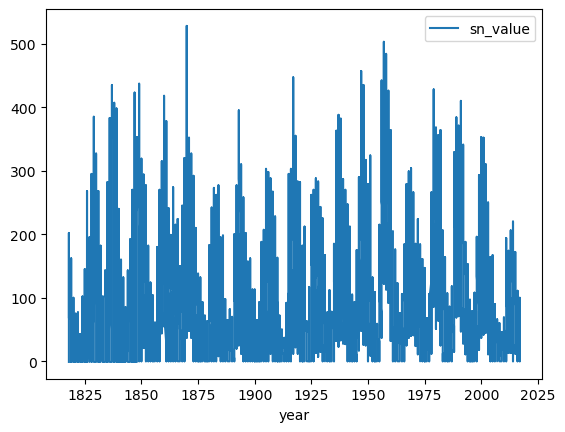

In [ ]:
df.plot(x='year', y='sn_value')

In [ ]:
# Data Preprocessing
start_id = max(df[df['obs_num'] == 0].index.tolist()) + 1
df = df[start_id:].copy()
df['sn_value'] = df['sn_value'].astype(float)
df_train = df[df['year'] < 2000]
df_test = df[df['year'] >= 2000]

spots_train = df_train['sn_value'].to_numpy().reshape(-1, 1)
spots_test = df_test['sn_value'].to_numpy().reshape(-1, 1)

scaler = StandardScaler()
spots_train = scaler.fit_transform(spots_train).flatten().tolist()
spots_test = scaler.transform(spots_test).flatten().tolist()

<Axes: xlabel='year'>

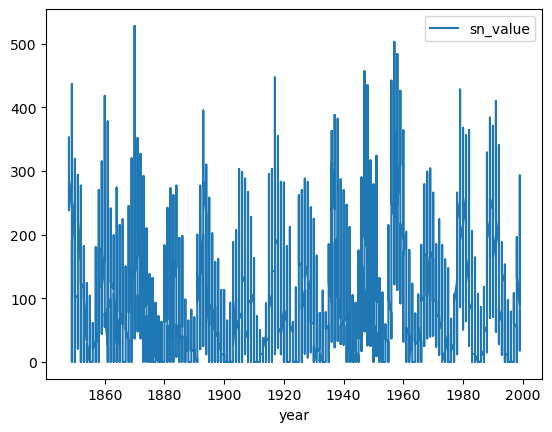

In [ ]:
df_train.plot(x='year', y='sn_value')

<Axes: xlabel='year'>

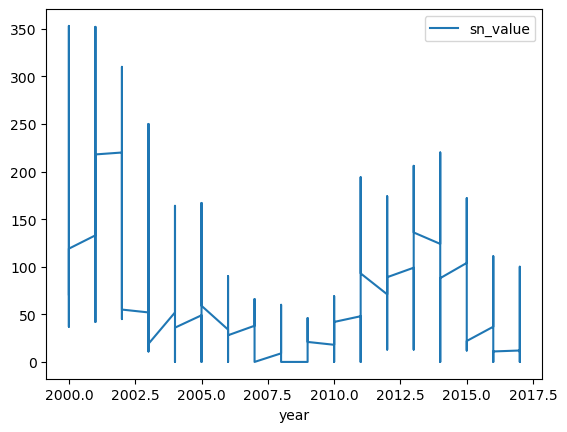

In [ ]:
df_test.plot(x='year', y='sn_value')

In [ ]:
# Sequence Data Preparation
SEQUENCE_SIZE = 10

def to_sequences(seq_size, obs):
    x = []
    y = []
    for i in range(len(obs) - seq_size):
        window = obs[i:(i + seq_size)]
        after_window = obs[i + seq_size]
        x.append(window)
        y.append(after_window)
    return torch.tensor(x, dtype=torch.float32).view(-1, seq_size, 1), torch.tensor(y, dtype=torch.float32).view(-1, 1)

x_train, y_train = to_sequences(SEQUENCE_SIZE, spots_train)
x_test, y_test = to_sequences(SEQUENCE_SIZE, spots_test)



In [ ]:
len(spots_train)

55160

In [ ]:
x_train.shape

torch.Size([55150, 10, 1])

In [ ]:
y_train.shape

torch.Size([55150, 1])

In [ ]:
x_train[0]

tensor([[3.3709],
        [1.9389],
        [2.3825],
        [3.3583],
        [2.2937],
        [2.5092],
        [3.2442],
        [3.2062],
        [1.9136],
        [2.5345]])

In [ ]:
y_train[0]

tensor([2.6232])

In [ ]:
x_train[1]

tensor([[1.9389],
        [2.3825],
        [3.3583],
        [2.2937],
        [2.5092],
        [3.2442],
        [3.2062],
        [1.9136],
        [2.5345],
        [2.6232]])

In [ ]:
y_train[1]

tensor([3.2315])

Next we set up data loaders for PyTorch, a crucial step when training neural networks in batches. First, the training data (**x_train** and **y_train**) is encapsulated into a TensorDataset. This structure pairs input data and its corresponding target, making it easier to manage. Similarly, the testing data (**x_test** and **y_test**) is also wrapped into a **TensorDataset**. Once the datasets are structured, they are passed to the **DataLoader** function.

For the training data, a **DataLoader** is created with a batch size of 32, and the shuffle parameter is set to True, which means tha during each epoch of training, the training data will be divided into batches of 32 samples, and these batches will be randomly shuffled. This shuffling is to ensure the model isn't exposed to any inherent order in the data during training, promoting better generalization.

Conversely, for the testing data, while the batch size remains 32, the shuffle parameter is set to False, indicating that the order of the test data remains unchanged. This is typical as shuffling the test data isn't necessary and can often make evaluation metrics easier to interpret. By the end of this code, two data loaders (train_loader and test_loader) are established, ready to feed data in batches to a neural network during both training and evaluation phases.

In [ ]:
# Setup data loaders for batch
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


We define an **LSTMModel** class, which is a neural network architecture using PyTorch that provides more precise control than a sequence. This model is structured with an LSTM layer followed by a dropout layer for regularization and two subsequent fully connected layers. The LSTM layer processes input sequences, producing a series of hidden states. The model then utilizes only the last hidden state of this series, passing it through the dropout layer and the two linear layers in sequence. This architecture is geared towards processing sequential data, where the LSTM can capture temporal dependencies and the fully connected layers further refine the representation for the final output.

In [ ]:
# Model definition
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])
        x = self.fc1(x)
        x = self.fc2(x)
        return x

model = LSTMModel().to(device)


The code outlines the training process for a neural network model. It sets up a mean squared error (MSE) loss function and uses the Adam optimizer with a learning rate of 0.001. The learning rate scheduler, **ReduceLROnPlateau**, adjusts the learning rate when the validation loss plateaus, decreasing it by a factor of 0.5 if there's no improvement for three epochs. The model trains for a maximum of 1000 epochs but incorporates early stopping; if the validation loss doesn't improve for five consecutive epochs, the training halts prematurely. During each epoch, the model's weights are updated using the training data. Subsequently, the model's performance is evaluated on the validation data, and the average validation loss is computed. The progress of the training, including the current epoch and corresponding validation loss, is printed to the console.

In [ ]:
from tqdm import tqdm

In [ ]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

epochs = 1000
early_stop_count = 0
# min_val_loss = float('inf')

losses = []

tqdm_iter = tqdm(range(epochs))
for epoch in tqdm_iter:
    train_loss = 0.0
    model.train()
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        train_loss += loss.item()

    train_loss /= len(train_loader)
    tqdm_iter.set_description(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}")

    # Validation
    # model.eval()
    # val_losses = []
    # with torch.no_grad():
    #     for batch in test_loader:
    #         x_batch, y_batch = batch
    #         x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    #         outputs = model(x_batch)
    #         loss = criterion(outputs, y_batch)
    #         val_losses.append(loss.item())

    # val_loss = np.mean(val_losses)
    # scheduler.step(val_loss)

    # if val_loss < min_val_loss:
    #     min_val_loss = val_loss
    #     early_stop_count = 0
    # else:
    #     early_stop_count += 1

    # if early_stop_count >= 5:
    #     print("Early stopping!")
    #     break
    # print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")



/home/mgj/miniconda3/envs/cal/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1000/1000, Train Loss: 0.0373: 100%|██████████| 1000/1000 [52:46<00:00,  3.17s/it]


[<matplotlib.lines.Line2D>]

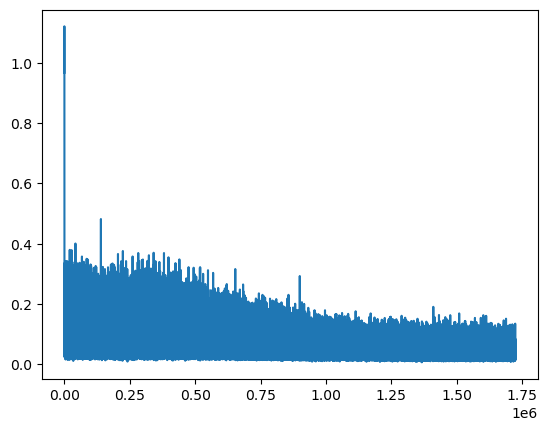

In [ ]:
plt.plot(losses)

In [ ]:
# Evaluation
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions.extend(outputs.squeeze().tolist())

rmse = np.sqrt(np.mean((scaler.inverse_transform(np.array(predictions).reshape(-1, 1)) - scaler.inverse_transform(y_test.numpy().reshape(-1, 1)))**2))
print(f"Score (RMSE): {rmse:.4f}")

Score (RMSE): 17.6341


In [ ]:
y_test.shape

torch.Size([6381, 1])

In [ ]:
np.array(predictions).shape

(6381,)

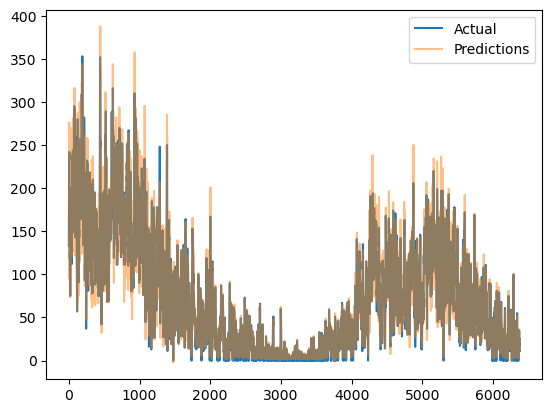

In [ ]:
plt.plot(scaler.inverse_transform(y_test.numpy().reshape(-1, 1)), label='Actual')
plt.plot((scaler.inverse_transform(np.array(predictions).reshape(-1, 1))), label='Predictions', alpha=0.5)
plt.legend()
plt.show()

In [ ]:
from tqdm import tqdm

In [ ]:
# Evaluation
model.eval()
last_window = x_test[0].unsqueeze(0)  # [1, 10, 1]   [batch_size, seq_size, num_values]    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

predictions = []

for i in tqdm(range(len(y_test))):

    with torch.no_grad():
        last_window = last_window.to(device)
        
        last_prediction = model(last_window)  # [1, 1] [batch_size, num_values]

        # append prediction
        predictions.append(last_prediction[0].detach().cpu().numpy())  

        # update last window using previously predicted value
        torch.roll(last_window, -1)  # [1, 10, 1]   [batch_size, seq_size, num_values]    [1, 2, 3, 4, 5, 6, 7, 8, 9, 0]

        # update last value with predicted value
        last_window[0, -1, 0] = last_prediction[0]  # [1, 10, 1]  [1, 2, 3, 4, 5, 6, 7, 8, 9, last_prediction]

100%|██████████| 6381/6381 [00:02<00:00, 2542.95it/s]


In [ ]:
rmse = np.sqrt(np.mean((scaler.inverse_transform(np.array(predictions).reshape(-1, 1)) - scaler.inverse_transform(y_test.numpy().reshape(-1, 1)))**2))
print(f"Score (RMSE): {rmse:.4f}")

Score (RMSE): 65.4793


In [ ]:
y_test.shape

torch.Size([6381, 1])

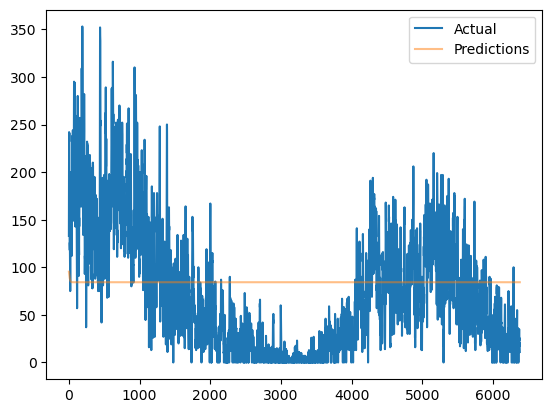

In [ ]:
plt.plot(scaler.inverse_transform(y_test.numpy().reshape(-1, 1)), label='Actual')
plt.plot((scaler.inverse_transform(np.array(predictions).reshape(-1, 1))), label='Predictions', alpha=0.5)
plt.legend()
plt.show()